# Modeling Script

> Models Available For This Project

In [ ]:
#| default_exp scripts.modeling

In [ ]:
#| hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#| export

from fastcore.script import Param, call_parse

from LTBP.data.utils import snowflake_query, get_yaml_dicts
from LTBP.modeling.utils import (
    create_stage_and_query_stage_sf, create_sklearn_preprocess_baseline_dict,
    return_list_of_vars, prepare_training_set, save_sklearn_object_to_data_lake
)
from LTBP.modeling.custom_utils import evaluate, send_holdout_results_to_sf

from machine_learning_utilities import preprocessing

from machine_learning_utilities.project_log import project_log

from sklearn.pipeline import Pipeline

import LTBP.modeling.models as ds_models
import os
import logging
import json

/Users/jeremydemlow/miniforge3/envs/ltbp/lib/python3.9/site-packages/snowflake/connector/options.py:96: UserWarning: You have an incompatible version of 'pyarrow' installed (6.0.0), please install a version that adheres to: 'pyarrow<8.1.0,>=8.0.0; extra == "pandas"'
  warn_incompatible_dep(


In [ ]:
#| hide
from pathlib import Path
import yaml

In [ ]:
#| skip
def write_yaml_file(file_path: str, file_name: str, dictionary: dict):
    with open(Path(file_path, file_name), 'w') as f:
        yaml.dump(dictionary, f)

models_dict = dict({
    'preprocessors_adls_path' : 'preprocessors/',
    'modeling_adls_path' : 'modeling/',
    'connection_str': 'DATALAKE_CONN_STR_SECRET',
    'hold_out_table' : 'LTBP_HOLDOUT_TEST_MODEL_RESULTS',
    'tracking_table' : 'LTBP_MODEL_TRACKING_FY23',
    'idenfication': ['ECID', 'SEASONYEAR'],
    'BASELINE': {
        'description': 'Standard baseline xgb_hyperopt approach status quo of LTBP of the past',
        'model_trainer': 'train_xgb',
        'y_preprocess_object_name': None,
        'y_scaler_type' : None,
        'x_preprocess_object_name': 'standard_pipe.pickle',
        'hyperopt_evals' : 2,
        'hyper_opt_subsample_size': 2750000,
        'training_subsample_size' : 5000000,

    },
    'NOHYPEROPT': {
        'description': 'Only here to see if it works delete at some point xgb_fit_only',
        'model_trainer': 'train_xgb_basic',
        'y_preprocess_object_name': None,
        'y_scaler_type' : None,
        'x_preprocess_object_name': 'standard_pipe.pickle',
        'hyper_opt_subsample_size' : None,
        'hyer_opt_subsample_size': None,
        'training_subsample_size' : 5000000,
    }
})

write_yaml_file('./LTBP/files/yaml_files/', 'models.yaml', models_dict)

This is the DSDE standard process for using Xboost with hyperopt

In [ ]:
#| export




@call_parse
def model_train(
    yaml_file_list: Param(help="YAML files to read", type=list, default=['features.yaml', 'udf_inputs.yaml', 'etl.yaml', 'models.yaml']),  # noqa:
    experiment_name: Param(help="YAML section to read", type=str, default='BASELINE'),  # noqa:
    experiment: Param(help="YAML section to read", type=bool, default=True),  # noqa:
    test_set: Param(help="Create a Test Set From Training Data", type=bool, default=True),  # noqa:
    prod_or_dev: Param(help="dev queries dev schema anything else will query project schema", type=str, default='dev')  # noqa:
    ):  # noqa:

    # Grab all yaml files for current probject
    features, udf_inputs, etl_dict, models_dict = get_yaml_dicts(yaml_file_list)

    # Create Snowflake Stage and Query Experiment location or commit location and return training data
    sf = snowflake_query(sfSchema=prod_or_dev if prod_or_dev.lower() == 'dev' else 'LTBP')
    df = create_stage_and_query_stage_sf(
        sf=sf,
        etl=etl_dict,
        udf_inputs=udf_inputs,
        train_or_inference='TRAINING',
        experiment_name=experiment_name,
        experiment=experiment,
        indentification=models_dict['idenfication']
    )

    # Choosing an adls path depending on experiment being true or false
    adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
                              if experiment
                              else os.path.join(etl_dict['data_lake_path'],
                                                os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))), models_dict['preprocessors_adls_path'])

    # Grab all Categorical and Continous Variables for Modeling
    cat_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
                if values['var_type'][experiment_name] == 'cat'
                and values['input_definition'] != 'LABEL']
    cont_vars = [{f.upper(): values['transformation'][experiment_name]} for f, values in features.items()
                 if values['var_type'][experiment_name] == 'cont'
                 and values['input_definition'] != 'LABEL']
    y_var = [k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL']

    # Create Dictionary and create sklearn preprocessing Pipeline
    feature_dict = create_sklearn_preprocess_baseline_dict(cat_vars=cat_vars,
                                                           cont_vars=cont_vars)
    logging.info(feature_dict)
    cat_vars = return_list_of_vars(cat_vars)
    cont_vars = return_list_of_vars(cont_vars)
    logging.info(f"categorical variables: \n {cat_vars}")
    logging.info(f"continous variables: \n {cont_vars}")
    pipe = preprocessing.generate_sklearn_preprocessing_pipeline(
        feature_dict, impute=True, impute_strategy='mean'
    )

    # Preprocess and split data set to return neccessary object for modeling
    result = prepare_training_set(df,
                                  y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL'],
                                  y_scaler_type=models_dict[experiment_name]['y_scaler_type'],
                                  adls_path=adls_path,
                                  sklearn_pipe=pipe,
                                  test_set=test_set,
                                  etl_dict=etl_dict,
                                  models_dict=models_dict,
                                  connection_str=os.environ[models_dict["connection_str"]],
                                  experiment_name=experiment_name,
                                  as_type=int,
                                  identifiers=['ECID', 'SEASONYEAR']
                                  )
    if test_set:
        X_train, X_valid, X_test, y_train, y_valid, y_test, sklearn_pipe, scaler, id_list = result
    else:
        X_train, X_valid, y_train, y_valid, sklearn_pipe, scaler, id_list = result

    # Choosing model from models.py to use from models.yaml file
    model_trainer = getattr(ds_models, models_dict[experiment_name]['model_trainer'])
    model = model_trainer(X_train,
                          X_valid,
                          y_train,
                          y_valid,
                          evals=models_dict[experiment_name]['hyperopt_evals'],
                          sub=models_dict[experiment_name]['hyper_opt_subsample_size'],
                          train=models_dict[experiment_name]['training_subsample_size'])

    """
    Custom needs for each project type this works for a binary classification
    this is not my best work, but trying to put something together
    this is dry I am sure i could make this just a few lines
    """
    result_dict = {}
    logging.info('Training Set Evaluation')

    eval_list_train = evaluate(model, X_train, y_train, y_var, feature_importance=True, plot=True)
    metric1, metric2, metric3, columns, _, _, fi_permutation = eval_list_train
    result_dict['training_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_train'] = {k: v for k, v in fi_permutation[:10].values}
    logging.info('Validation Set Evaluation')
    eval_list_valid = evaluate(model, X_valid, y_valid, y_var, feature_importance=True, plot=True)
    metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_valid
    result_dict['valid_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_valid'] = {k: v for k, v in fi_permutation[:10].values}
    if X_test is not None:
        logging.info('Test Set Evaluation')
        eval_list_test = evaluate(model, X_test, y_test, y_var, feature_importance=True, plot=True)
        metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_test
        result_dict['test_metrics'] = {k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
        result_dict['fi_test'] = {k: v for k, v in fi_permutation[:10].values}

    sf = snowflake_query(sfSchema='LTBP')
    send_holdout_results_to_sf(sf=sf,
                               id_list=id_list,
                               probs=y_pred_proba,
                               experiment=experiment,
                               experiment_name=experiment_name,
                               etl_dict=etl_dict,
                               model_dict=models_dict)

    adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
                              if experiment
                              else os.path.join(etl_dict['data_lake_path'],
                                                os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))))

    project_log_df = project_log.project_log(
        snowflake_connection=sf,
        table_name=models_dict['tracking_table'],
        action_description=models_dict[experiment_name]["description"],
        transaction_type="model_training",
        artifacts=json.dumps({"azure_parent_folder": adls_path}),
        metrics=json.dumps(result_dict),
        append_or_replace="append",
    )
    logging.info(f'project log preview:\n{project_log_df.head(2)}')

    # Saving sklearn pipeline to adls
    logging.info('Saving model and sending it to adls')
    full_pipeline = Pipeline([('preprocessing', pipe), ('classification', model)])
    adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
                              if experiment
                              else os.path.join(etl_dict['data_lake_path'],
                                                os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))), models_dict['modeling_adls_path'])
    save_sklearn_object_to_data_lake(
        save_object=full_pipeline,
        adls_path=adls_path,
        file_name=models_dict[experiment_name]['model_trainer']+os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')+'.pkl',
        container_name=etl_dict['azure_container'],
        connection_str=os.environ[models_dict['connection_str']]
    )

Here is where the development of the script can be improved this code should run sequentially happy coding

INFO:data_system_utilities.snowflake.utils:stage_query: 
 create or replace stage ltbpFY23LocalRunTest
url='azure://vaildtscadls.blob.core.windows.net/vailadls/projects/LTBP/FY23/experiments/BASELINE'
credentials=(azure_sas_token='**MASKED**')
encryption=(type= 'NONE')
file_format = (type = parquet        )
INFO:data_system_utilities.snowflake.utils:connection to snowflake established...
INFO:data_system_utilities.snowflake.query:executing query
INFO:data_system_utilities.snowflake.query:data loaded from snowflake
INFO:data_system_utilities.snowflake.query:connection to snowflake has been turned off
INFO:data_system_utilities.snowflake.query:Stage area LTBPFY23LOCALRUNTEST successfully created.
INFO:root:adls snowflake stage query 
    select
    $1:"ECID"::varchar as ECID
, $1:"SEASONYEAR"::varchar as SEASONYEAR
, $1:"AGE"::varchar as AGE
, $1:"AVGVISITPERSEASON"::varchar as AVGVISITPERSEASON
, $1:"BOUGHTPASS"::varchar as BOUGHTPASS
, $1:"DESTINATIONGEOAFINITYLABEL"::varchar as DESTIN

INFO:machine_learning_utilities.preprocessing:Feature: DESTINATIONGEOAFINITYLABEL --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: EVERCOREPASS --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: EVERPASS --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: GENDERCODE --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: GUESTBEHAVIOR --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: ISEPICMIXACTIVATED --> Transformer: OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
INFO:machine_learning_utilities.preprocessing:Feature: MARKET

  0%|                       | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.008295 seconds
INFO:hyperopt.tpe:TPE using 0 trials


 50%|▌| 1/2 [00:05<00:05,  5.24s/trial, best loss: 0.1024154280251

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007656 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.102415


100%|█| 2/2 [00:11<00:00,  5.76s/trial, best loss: 0.1024154280251

INFO:root:Full training on 24000 rows


INFO:root:Training Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.930    Accuracy: 0.852    Balanced Accuracy: 0.853
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.2774
1         MOSTCOMMONTICKETCOMP  0.0386
2            SUBSEASONSPERYEAR  0.0308
3                GUESTBEHAVIOR  0.0220
4                          AGE  0.0178
5                  TOTALVISITS  0.0128
6          TOTALSEASONSSCANNED  0.0108
7   DESTINATIONGEOAFINITYLABEL  0.0102
8                 EVERCOREPASS  0.0094
9            MOSTVISITEDRESORT  0.0082
10           MOSTVISITEDREGION  0.0078
11           AVGVISITPERSEASON  0.0072
12               MARKETINGZONE  0.0052
13        MOSTSUBSEASONVISITED  0.0046
14              RESORTSVISITED  0.0032
15         ONLYSINGLERESORTKEY  0.0030
16          ISEPICMIXACTIVATED  0.0024
17                  GENDERCODE  0.0012
18    PARTNERRESORTSCANNERFLAG  0.0010
19           SKIERABILITYLABEL  0.0008
20   

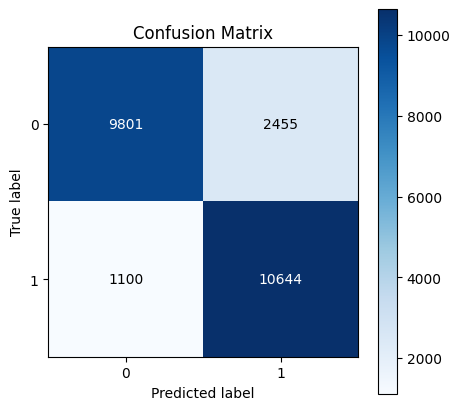

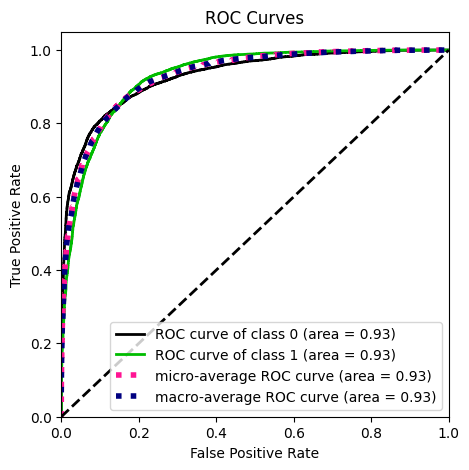

INFO:root:Validation Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.898    Accuracy: 0.815    Balanced Accuracy: 0.818
INFO:root:Feature Importance df: 
                           COLS     IMP
0                     EVERPASS  0.2526
1         MOSTCOMMONTICKETCOMP  0.0270
2            SUBSEASONSPERYEAR  0.0158
3                GUESTBEHAVIOR  0.0114
4           ISEPICMIXACTIVATED  0.0066
5                 EVERCOREPASS  0.0034
6                  TOTALVISITS  0.0022
7         MOSTSUBSEASONVISITED  0.0014
8                MARKETINGZONE  0.0010
9            SKIERABILITYLABEL  0.0006
10              RESORTSVISITED  0.0006
11                  GENDERCODE  0.0004
12           AVGVISITPERSEASON -0.0002
13    PARTNERRESORTSCANNERFLAG -0.0002
14         ONLYSINGLERESORTKEY -0.0002
15                         AGE -0.0004
16           MOSTVISITEDREGION -0.0016
17             VISITMOSTINPEAK -0.0018
18           MOSTVISITEDRESORT -0.0022
19         TOTALSEASONSSCANNED -0.0026
20 

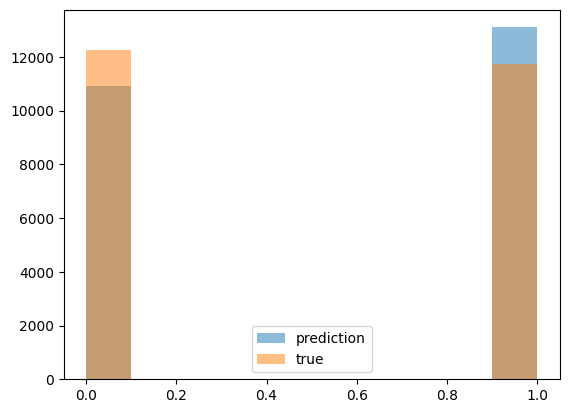

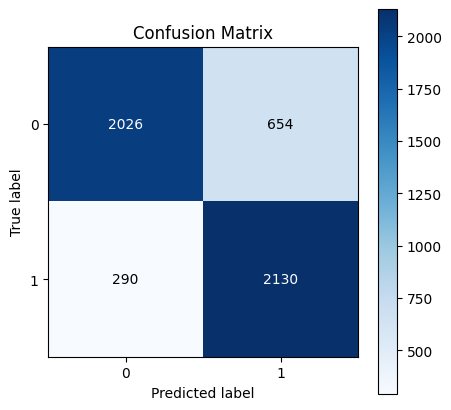

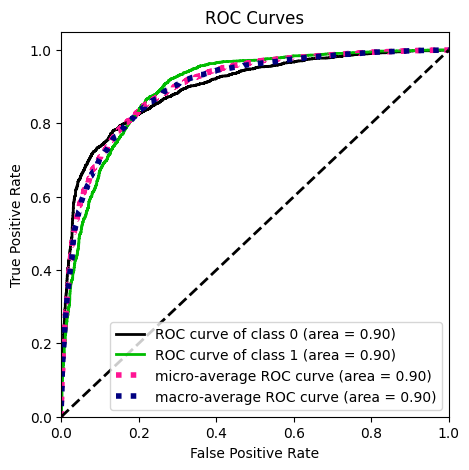

INFO:root:Test Set Evaluation
INFO:root:Variable(s) of interest ['BOUGHTPASS'] AUC: 0.897    Accuracy: 0.823    Balanced Accuracy: 0.825
INFO:root:Feature Importance df: 
                           COLS       IMP
0                     EVERPASS  0.253333
1         MOSTCOMMONTICKETCOMP  0.026667
2                          AGE  0.021111
3            SUBSEASONSPERYEAR  0.015556
4   DESTINATIONGEOAFINITYLABEL  0.014444
5          TOTALSEASONSSCANNED  0.010000
6          ONLYSINGLERESORTKEY  0.007778
7            AVGVISITPERSEASON  0.006667
8                 EVERCOREPASS  0.005556
9               RESORTSVISITED  0.005556
10           MOSTVISITEDRESORT  0.005556
11               GUESTBEHAVIOR  0.005556
12          ISEPICMIXACTIVATED  0.004444
13           MOSTVISITEDREGION  0.003333
14           SKIERABILITYLABEL  0.003333
15        MOSTSUBSEASONVISITED  0.003333
16                  GENDERCODE  0.003333
17    PARTNERRESORTSCANNERFLAG  0.000000
18             VISITMOSTINPEAK  0.000000
19      

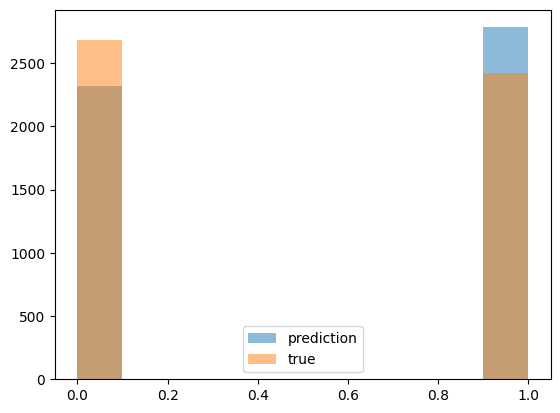

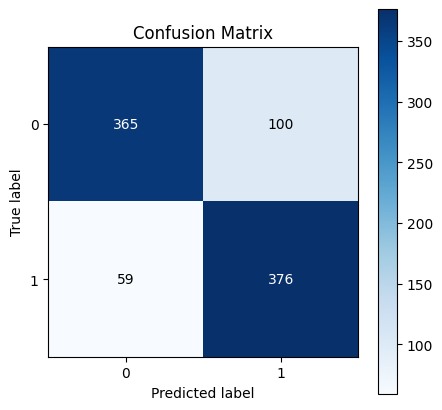

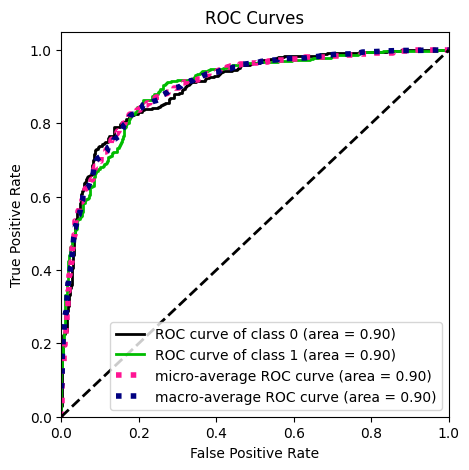

INFO:root:hold out data preview going to snowflake            ECID SEASONYEAR  PROBABILITY          DATECREATED  \
14448    229265    2018/19     0.847043  2022-10-27 11:04:34   
12515  52163122    2018/19     0.891722  2022-10-27 11:04:34   
2167    8972070    2018/19     0.640274  2022-10-27 11:04:34   

           EXP_COMMIT_CI_SHA  
14448  BASELINE_LocalRunTest  
12515  BASELINE_LocalRunTest  
2167   BASELINE_LocalRunTest  
INFO:data_system_utilities.snowflake.query:creating table LTBP_HOLDOUT_TEST_MODEL_RESULTS
INFO:data_system_utilities.snowflake.query:sqlalchemy snowflake engine created
INFO:data_system_utilities.snowflake.query:table created
INFO:root:saving test prediction file
INFO:root:sending prediction file to azure to projects/LTBP/FY23/experiments/BASELINE/holdout_results/
INFO:data_system_utilities.azure.storage:Uploading holdout_BASELINELocalRunTest.csv, to Azure Storage projects/LTBP/FY23/experiments/BASELINE/holdout_results/holdout_BASELINELocalRunTest.csv
INFO:data_

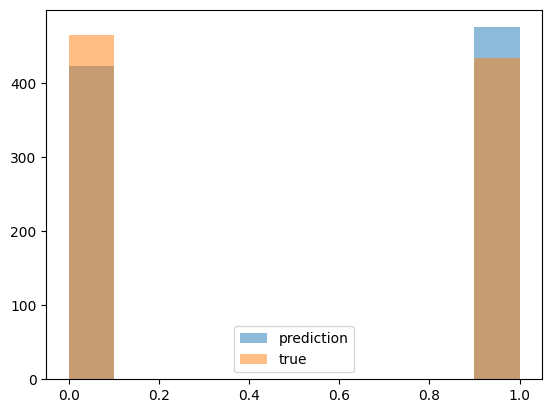

In [ ]:
#| skip

yaml_file_list=['features.yaml', 'udf_inputs.yaml','etl.yaml','models.yaml']
prod_or_dev = 'dev'
experiment_name='BASELINE'
experiment = True # this will trigger if the feature set needs to be created
test_set = True

# Grab all yaml files for current probject
features, udf_inputs, etl_dict, models_dict = get_yaml_dicts(yaml_file_list)

# Create Snowflake Stage and Query Experiment location or commit location and return training data
sf = snowflake_query(sfSchema=prod_or_dev if prod_or_dev.lower() == 'dev' else 'LTBP')
df = create_stage_and_query_stage_sf(
    sf=sf,
    etl=etl_dict,
    udf_inputs=udf_inputs,
    train_or_inference='TRAINING',
    experiment_name=experiment_name,
    experiment=experiment,
    indentification=models_dict['idenfication']
    )

# Choosing an adls path depending on experiment being true or false
adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
    if experiment 
    else os.path.join(etl_dict['data_lake_path'], 
    os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')))
    , models_dict['preprocessors_adls_path'])

# Grab all Categorical and Continous Variables for Modeling
cat_vars =[{f.upper() : values['transformation'][experiment_name]} for f, values in features.items() 
            if values['var_type'][experiment_name] == 'cat'
            and values['input_definition'] != 'LABEL']
cont_vars =[{f.upper(): values['transformation'][experiment_name]} for f, values in features.items() 
            if values['var_type'][experiment_name] == 'cont'
            and values['input_definition'] != 'LABEL']
y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL']

# Create Dictionary and create sklearn preprocessing Pipeline
feature_dict = create_sklearn_preprocess_baseline_dict(cat_vars=cat_vars, 
                                                       cont_vars=cont_vars)
logging.info(feature_dict)
cat_vars = return_list_of_vars(cat_vars)
cont_vars = return_list_of_vars(cont_vars)
logging.info(f"categorical variables: \n {cat_vars}")
logging.info(f"continous variables: \n {cont_vars}")
pipe = preprocessing.generate_sklearn_preprocessing_pipeline(
    feature_dict, impute=True, impute_strategy='mean'
)

# Preprocess and split data set to return neccessary object for modeling
result = prepare_training_set(df,
                              y_var=[k.upper() for k, v in features.items() if v['input_definition'] == 'LABEL'],
                              y_scaler_type=models_dict[experiment_name]['y_scaler_type'],
                              adls_path=adls_path,
                              sklearn_pipe=pipe,
                              test_set=test_set,
                              etl_dict=etl_dict,
                              models_dict=models_dict,
                              connection_str=os.environ[models_dict["connection_str"]],
                              experiment_name=experiment_name,
                              as_type=int,
                              identifiers=['ECID', 'SEASONYEAR']
                              )
if test_set:
    X_train, X_valid, X_test, y_train, y_valid, y_test, sklearn_pipe, scaler, id_list = result
else:
    X_train, X_valid, y_train, y_valid, sklearn_pipe, scaler, id_list = result


# Choosing model from models.py to use from models.yaml file
model_trainer = getattr(ds_models, models_dict[experiment_name]['model_trainer'])
model = model_trainer(X_train,
                      X_valid,
                      y_train,
                      y_valid,
                      evals=models_dict[experiment_name]['hyperopt_evals'],
                      sub=models_dict[experiment_name]['hyper_opt_subsample_size'],
                      train=models_dict[experiment_name]['training_subsample_size'])

"""
Custom needs for each project type this works for a binary classification
this is not my best work, but trying to put something together 
this is dry I am sure i could make this just a few lines 
"""
result_dict = {}
logging.info('Training Set Evaluation')

eval_list_train = evaluate(model, X_train, y_train, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, _, _, fi_permutation = eval_list_train
result_dict['training_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_train']={k:v for k, v in fi_permutation[:10].values}
logging.info('Validation Set Evaluation')
eval_list_valid = evaluate(model, X_valid, y_valid, y_var, feature_importance=True, plot=True)
metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_train
result_dict['valid_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
result_dict['fi_valid']={k:v for k, v in fi_permutation[:10].values}
if X_test is not None:
    logging.info('Test Set Evaluation')
    eval_list_test = evaluate(model, X_test, y_test, y_var, feature_importance=True, plot=True)
    metric1, metric2, metric3, columns, y_pred_proba, y_pred, fi_permutation = eval_list_test
    result_dict['test_metrics']={k: v for k, v in zip(columns, [metric1]+[metric2]+[metric3])}
    result_dict['fi_test']={k:v for k, v in fi_permutation[:10].values}

sf = snowflake_query(sfSchema='LTBP')
send_holdout_results_to_sf(sf=sf,
                           id_list=id_list,
                           probs=y_pred_proba,
                           experiment=experiment,
                           experiment_name=experiment_name,
                           etl_dict=etl_dict,
                           model_dict=models_dict)

adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
    if experiment 
    else os.path.join(etl_dict['data_lake_path'], 
    os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS'))))

project_log_df = project_log.project_log(
    snowflake_connection=sf,
    table_name=models_dict['tracking_table'],
    action_description=models_dict[experiment_name]["description"],
    transaction_type="model_training",
    artifacts=json.dumps({"azure_parent_folder": adls_path}),
    metrics=json.dumps(result_dict),
    append_or_replace="append",
)
logging.info(f'project log preview:\n{project_log_df.head(2)}')

# Saving sklearn pipeline to adls
logging.info('Saving model and sending it to adls')
full_pipeline = Pipeline([('preprocessing', pipe), ('classification', model)])
adls_path = os.path.join((os.path.join(etl_dict['data_lake_path'], 'experiments', experiment_name)
    if experiment 
    else os.path.join(etl_dict['data_lake_path'], 
    os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')))
    , models_dict['modeling_adls_path'])
save_sklearn_object_to_data_lake(
    save_object=full_pipeline,
    adls_path=adls_path,
    file_name=models_dict[experiment_name]['model_trainer']+os.environ.get('CI_COMMIT_SHA', 'LocalRunNBS')+'.pkl',
    container_name=etl_dict['azure_container'],
    connection_str=os.environ[models_dict['connection_str']]
)

These just help clean up the tables that would be created by this notebook make sure you only use the below code when in development otherwise you production or your dev results that you have could be deleted.

In [ ]:
#| skip
# sf.run_sql_str(f"DROP TABLE {models_dict['tracking_table']}")
# sf.run_sql_str(f"DROP TABLE MACHINELEARNINGOUTPUTS.dev.{models_dict['hold_out_table']}")